In [34]:
# === Optimized Forex Transformer Prediction with Accuracy Plot ===
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader



In [35]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")



✅ Using device: cuda


In [36]:
# --- Load and preprocess ---
symbols = ['USDJPY=X', 'EURUSD=X', 'GBPUSD=X']
clean_names = ['USDJPY', 'EURUSD', 'GBPUSD']
features = ['Close', 'MA10', 'MA50', 'STD20', 'RSI']

fx_data = {}
for symbol in symbols:
    data = yf.download(symbol, period="3y", interval="1d")
    data['MA10'] = data['Close'].rolling(10).mean()
    data['MA50'] = data['Close'].rolling(50).mean()
    data['STD20'] = data['Close'].rolling(20).std()
    pct_change = data['Close'].pct_change()
    data['RSI'] = 100 - (100 / (1 + pct_change.rolling(14).mean() / pct_change.rolling(14).std()))
    fx_data[symbol] = data[features].dropna()

min_len = min(len(df) for df in fx_data.values())
aligned_data = [fx_data[s][-min_len:].to_numpy() for s in symbols]
fx_combined = np.stack(aligned_data, axis=1).transpose(1, 0, 2)
df_dict = {name: pd.DataFrame(fx_combined[i], columns=features) for i, name in enumerate(clean_names)}

print("✅ Data loading and feature engineering complete.")



/tmp/ipykernel_6647/1386383229.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, period="3y", interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_6647/1386383229.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, period="3y", interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_6647/1386383229.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, period="3y", interval="1d")
[*********************100%***********************]  1 of 1 completed

✅ Data loading and feature engineering complete.


Training on USDJPY...
Epoch 0: loss = 0.351073, acc = 0.0313
Epoch 5: loss = 0.009083, acc = 0.1863
Epoch 10: loss = 0.004124, acc = 0.2623
Epoch 15: loss = 0.003669, acc = 0.2772
Epoch 20: loss = 0.003268, acc = 0.2668
Epoch 25: loss = 0.002825, acc = 0.3174
Epoch 30: loss = 0.002284, acc = 0.3577
Epoch 35: loss = 0.002158, acc = 0.3353


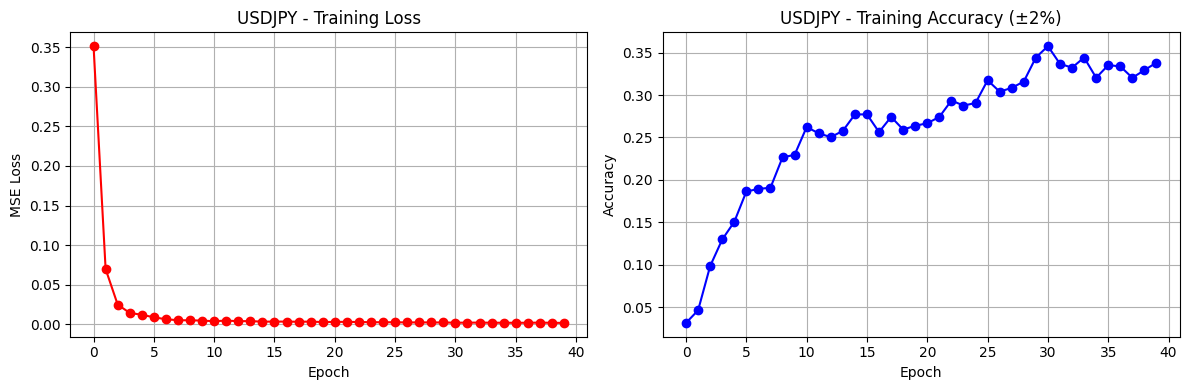

Training on EURUSD...
Epoch 0: loss = 0.452395, acc = 0.0253
Epoch 5: loss = 0.009208, acc = 0.1833
Epoch 10: loss = 0.005665, acc = 0.2206
Epoch 15: loss = 0.004057, acc = 0.2742
Epoch 20: loss = 0.003477, acc = 0.2459
Epoch 25: loss = 0.003372, acc = 0.2861
Epoch 30: loss = 0.002476, acc = 0.3174
Epoch 35: loss = 0.002140, acc = 0.3443


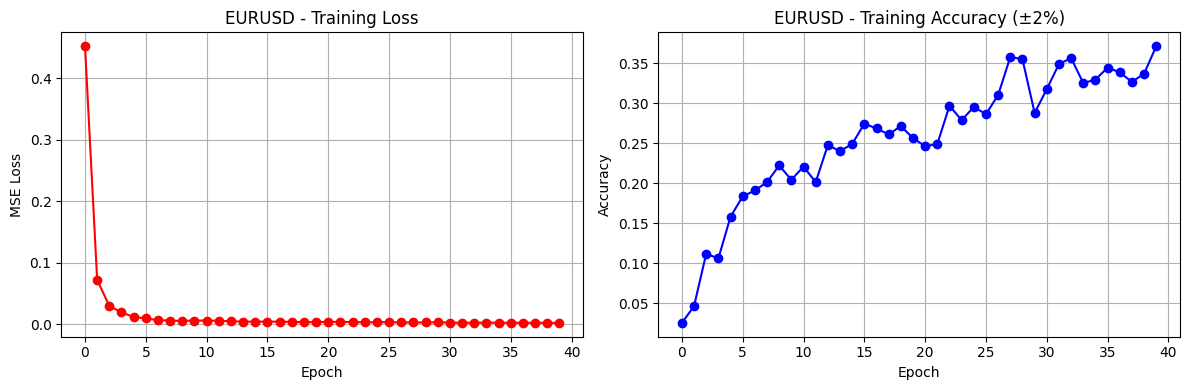

Training on GBPUSD...
Epoch 0: loss = 0.338601, acc = 0.0268
Epoch 5: loss = 0.011099, acc = 0.1624
Epoch 10: loss = 0.004844, acc = 0.2697
Epoch 15: loss = 0.003328, acc = 0.2876
Epoch 20: loss = 0.002320, acc = 0.3085
Epoch 25: loss = 0.002601, acc = 0.2981
Epoch 30: loss = 0.002130, acc = 0.3249
Epoch 35: loss = 0.001822, acc = 0.3413


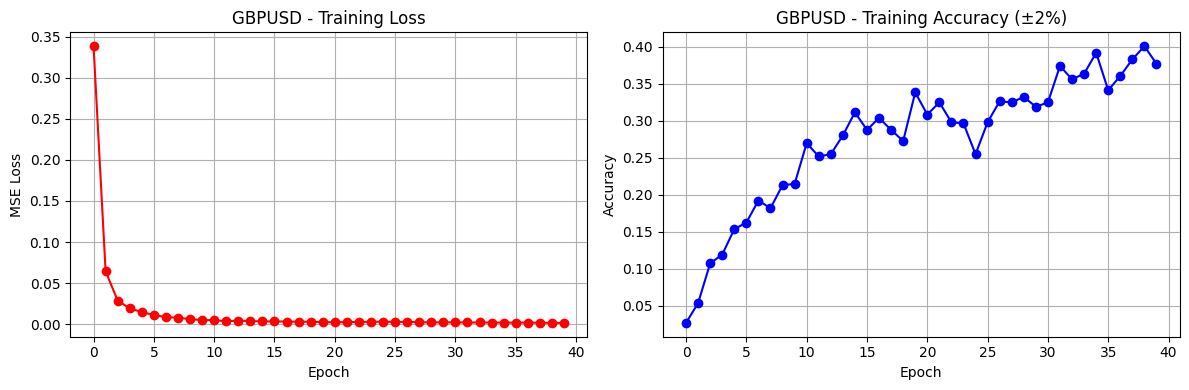

✅ All models trained.


In [37]:
# --- Transformer Model ---
class FXTransformer(nn.Module):
    def __init__(self, input_dim=5, seq_len=60, d_model=64, nhead=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        return self.fc(x[:, -1])

def create_sequences(data, seq_len=60):
    X = np.array([data[i:i+seq_len] for i in range(len(data) - seq_len)])
    y = data[seq_len:, 0]
    return X, y

currency_models = {}
currency_scalers = {}
currency_predictions = {}

for pair in clean_names:
    print(f"Training on {pair}...")
    raw = df_dict[pair].values
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(raw)
    X, y = create_sequences(scaled)
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y[:, None], dtype=torch.float32)

    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    model = FXTransformer().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=0.0005)
    loss_fn = nn.MSELoss()
    train_losses = []
    train_accuracies = []

    for epoch in range(40):
        model.train()
        batch_losses = []
        correct = 0
        total = 0
        for Xb, yb in loader:
            Xb, yb = Xb.to(device), yb.to(device)
            pred = model(Xb)
            loss = loss_fn(pred, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            batch_losses.append(loss.item())

            # Accuracy: consider prediction within 2% range as correct
            with torch.no_grad():
                abs_diff = torch.abs(pred - yb)
                correct += (abs_diff < 0.02).sum().item()
                total += yb.numel()

        epoch_acc = correct / total
        train_losses.append(np.mean(batch_losses))
        train_accuracies.append(epoch_acc)
        if epoch % 5 == 0:
            print(f"Epoch {epoch}: loss = {train_losses[-1]:.6f}, acc = {epoch_acc:.4f}")

    # --- Plot Loss & Accuracy ---
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(train_losses, label='Training Loss', color='red', marker='o')
    ax[0].set_title(f"{pair} - Training Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("MSE Loss")
    ax[0].grid(True)

    ax[1].plot(train_accuracies, label='Training Accuracy', color='blue', marker='o')
    ax[1].set_title(f"{pair} - Training Accuracy (±2%)")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

    # --- Prediction ---
    model.eval()
    with torch.no_grad():
        pred_scaled = model(X_tensor.to(device)).cpu().numpy()
        y_tensor_np = y_tensor.numpy()
        pred = scaler.inverse_transform(np.concatenate([pred_scaled, np.zeros((len(pred_scaled), 4))], axis=1))[:, 0]
        actual = scaler.inverse_transform(np.concatenate([y_tensor_np, np.zeros((len(y_tensor_np), 4))], axis=1))[:, 0]

    currency_models[pair] = model
    currency_scalers[pair] = scaler
    currency_predictions[pair] = (actual, pred)

print("✅ All models trained.")



USDJPY: RMSE = 1.1357, MAE = 0.8763


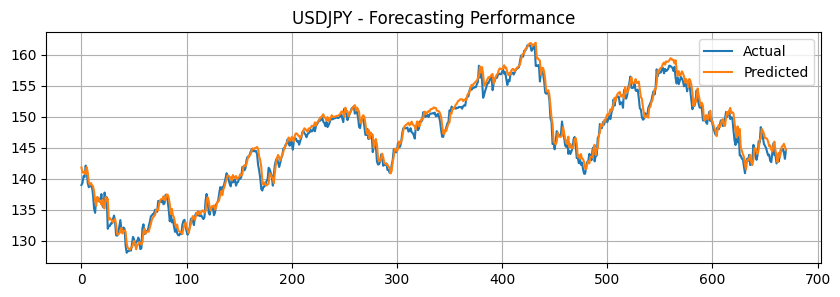

EURUSD: RMSE = 0.0076, MAE = 0.0063


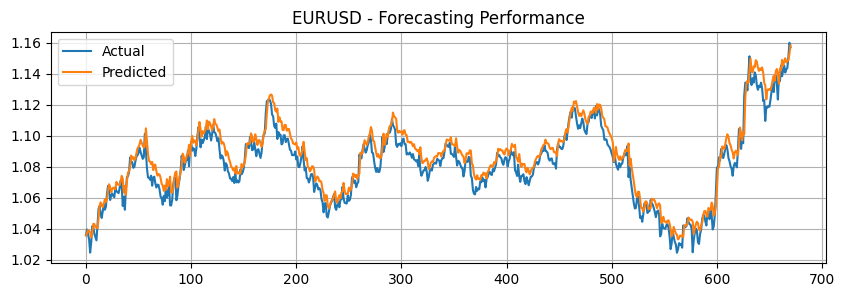

GBPUSD: RMSE = 0.0100, MAE = 0.0083


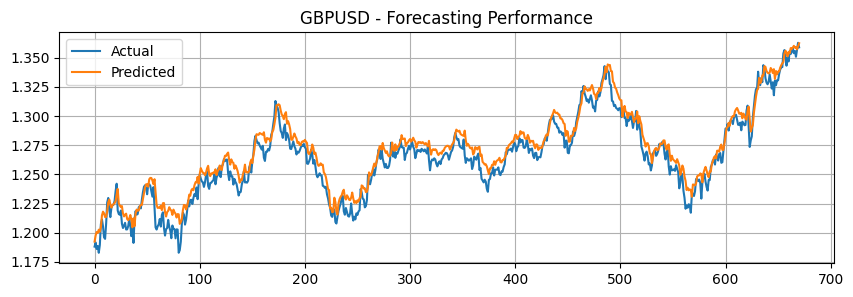

In [38]:
# --- Evaluation ---
for pair in clean_names:
    actual, pred = currency_predictions[pair]
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    print(f"{pair}: RMSE = {rmse:.4f}, MAE = {mae:.4f}")
    plt.figure(figsize=(10, 3))
    plt.plot(actual, label='Actual')
    plt.plot(pred, label='Predicted')
    plt.title(f"{pair} - Forecasting Performance")
    plt.legend()
    plt.grid(True)
    plt.show()




In [39]:
# --- Simulation ---
def trading_decision(prev, pred, threshold=0.002):
    change = (pred - prev) / prev
    if change > threshold:
        return "LONG"
    elif change < -threshold:
        return "SHORT"
    return "HOLD"

initial_capital = 1000.0
margin = 10.0
leverage = 5
liq_threshold = 0.3
capital = {k: initial_capital for k in clean_names}
position = {k: 0 for k in clean_names}
entry_price = {k: 0 for k in clean_names}

print("\n=== Running 90-Day Simulation ===")
start_day = len(df_dict[clean_names[0]]) - 120
end_day = len(df_dict[clean_names[0]]) - 30
for t in range(start_day, end_day):
    print(f"\nDay {t - start_day + 1}")
    for pair in clean_names:
        df = df_dict[pair]
        actual_price = df.iloc[t]['Close']

        scaler = currency_scalers[pair]
        model = currency_models[pair]

        input_data = df.iloc[t-60:t].values
        scaled_input = scaler.transform(input_data.reshape(-1, 5))
        input_tensor = torch.tensor(scaled_input.reshape(1, 60, 5), dtype=torch.float32).to(device)

        with torch.no_grad():
            pred_scaled = model(input_tensor).cpu().item()
            pred = scaler.inverse_transform([[pred_scaled] + [0]*4])[0][0]

        action = trading_decision(actual_price, pred)

        if position[pair] == 0:
            if action == "LONG":
                position[pair] = 10
                entry_price[pair] = actual_price
            elif action == "SHORT":
                position[pair] = -10
                entry_price[pair] = actual_price
        else:
            pnl = position[pair] * (actual_price - entry_price[pair]) * leverage * margin / actual_price
            equity = capital[pair] + pnl
            if equity / (margin * abs(position[pair])) < liq_threshold:
                print(f"\U0001F53B {pair}: Liquidation triggered")
                capital[pair] = equity
                position[pair] = 0
                entry_price[pair] = 0
            elif abs(pnl) > 50:
                print(f"\U0001F4B0 {pair}: Trade closed | PnL = ${pnl:.2f}")
                capital[pair] += pnl
                position[pair] = 0
                entry_price[pair] = 0

        print(f"{pair}: Action={action}, Capital=${capital[pair]:.2f}, Position={position[pair]}")




=== Running 90-Day Simulation ===

Day 1
USDJPY: Action=LONG, Capital=$1000.00, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=10
GBPUSD: Action=LONG, Capital=$1000.00, Position=10

Day 2
USDJPY: Action=HOLD, Capital=$1000.00, Position=10
EURUSD: Action=HOLD, Capital=$1000.00, Position=10
GBPUSD: Action=LONG, Capital=$1000.00, Position=10

Day 3
USDJPY: Action=LONG, Capital=$1000.00, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=10
GBPUSD: Action=HOLD, Capital=$1000.00, Position=10

Day 4
USDJPY: Action=LONG, Capital=$1000.00, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=10
GBPUSD: Action=LONG, Capital=$1000.00, Position=10

Day 5
USDJPY: Action=LONG, Capital=$1000.00, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=10
GBPUSD: Action=LONG, Capital=$1000.00, Position=10

Day 6
USDJPY: Action=LONG, Capital=$1000.00, Position=10
EURUSD: Action=LONG, Capital=$1000.00, Position=10
GBPUSD: Action=LONG, Capital=$1000.00, Position=10

Day 

In [40]:
# --- ROI ---
print("\n=== Final ROI Report ===")
total_initial = len(clean_names) * initial_capital
total_final = sum(capital.values())
for pair in clean_names:
    pnl = capital[pair] - initial_capital
    print(f"{pair}: Final = ${capital[pair]:.2f} | PnL = ${pnl:.2f}")
print(f"Total ROI: {(total_final / total_initial - 1) * 100:.2f}%")
print("✅ Simulation complete.")




=== Final ROI Report ===
USDJPY: Final = $946.43 | PnL = $-53.57
EURUSD: Final = $1000.00 | PnL = $0.00
GBPUSD: Final = $1000.00 | PnL = $0.00
Total ROI: -1.79%
✅ Simulation complete.


In [41]:
# --- Save Models ---
for pair, model in currency_models.items():
    torch.save(model.state_dict(), f"{pair}_fx2_transformer.pth")
    print(f"Model for {pair} saved.")

Model for USDJPY saved.
Model for EURUSD saved.
Model for GBPUSD saved.
